## Combining and Loading Dataset

In [ ]:
# Import warnings to avoid error
import warnings
warnings.filterwarnings("ignore")

# Import Hugging Face dataset loader
from datasets import load_dataset
# Import pandas for data manipulation
import pandas as pd

# Load the emotion dataset (train, validation, test splits)
dataset = load_dataset("dair-ai/emotion")

# Convert training split to DataFrame
train_df = pd.DataFrame(dataset["train"])

# Convert validation split to DataFrame
validation_df = pd.DataFrame(dataset["validation"])

# Convert test split to DataFrame
test_df = pd.DataFrame(dataset["test"])

# Concatenate train, validation, and test datasets
# ignore_index=True resets row indexing
full_df = pd.concat(
    [train_df, validation_df, test_df],
    ignore_index=True
)

# Display the shape of the combined dataset
print("Combined dataset shape:", full_df.shape)


Combined dataset shape: (20000, 2)


## Saving dataset to local directory

In [ ]:
# Save the combined dataset into a CSV file
# The file will be saved in the same directory as this notebook
full_df.to_csv("emotion_full_dataset.csv", index=False)

print("Dataset saved as emotion_full_dataset.csv to working directory")



Dataset saved as emotion_full_dataset.csv to working directory


In [ ]:
# Load the locally saved CSV file for further analysis
df = pd.read_csv("emotion_full_dataset.csv")

# Display first few rows
df.head()



,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


# Exploratory Data Analysis (EDA)

## 1) Dataset Overview

In [ ]:
# Display dataset structure and data types
df.info()

# Display descriptive statistics for all columns
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


,text,label
count,20000,20000.000000
unique,19948,NaN
top,i will feel as though i am accepted by as well...,NaN
freq,2,NaN
mean,NaN,1.562850
std,NaN,1.496684
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,3.000000


In [ ]:
# Create a dictionary to map label numbers to emotion names
emotion_map = {
    0: "Sadness",
    1: "Joy",
    2: "Love",
    3: "Anger",
    4: "Fear",
    5: "Surprise"
}

# Create a new column with emotion names
df["emotion"] = df["label"].map(emotion_map)


## 2) Distribution of Emotion Classes

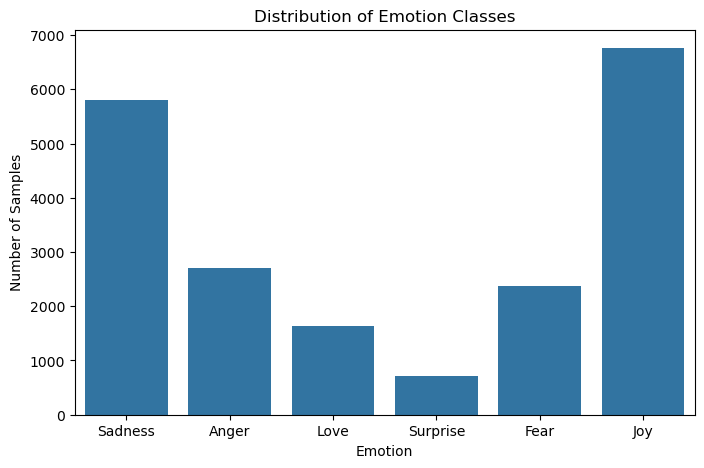

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution to check balance among emotion categories
plt.figure(figsize=(8,5))
sns.countplot(x="emotion", data=df)
plt.title("Distribution of Emotion Classes")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.show()


## 3) Distribution of Text Lengths

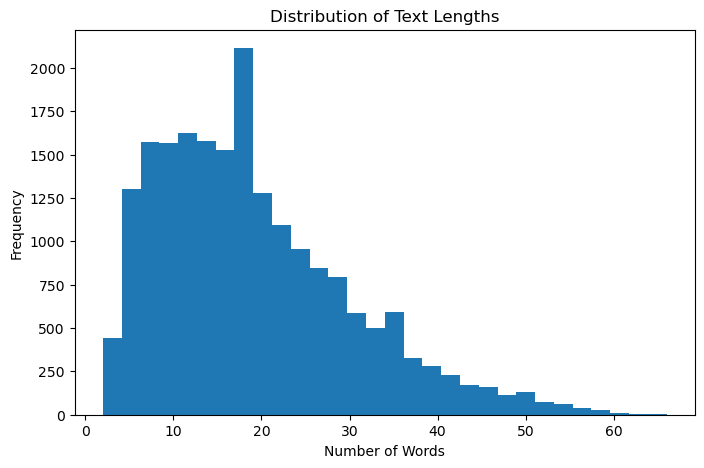

In [ ]:
# Calculate the number of words in each text sample
df["text_length"] = df["text"].apply(lambda x: len(x.split()))

# Plot histogram of text lengths
plt.figure(figsize=(8,5))
plt.hist(df["text_length"], bins=30)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


## 4) Text Length Distribution by Emotion

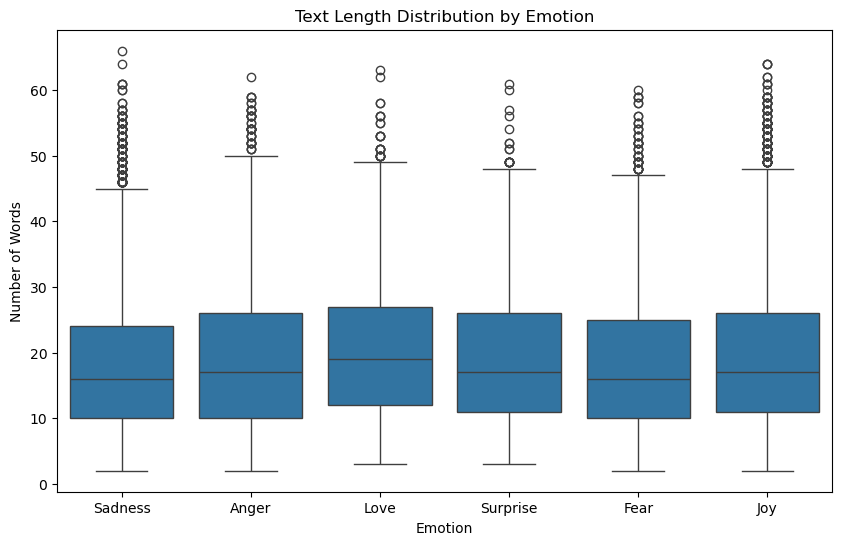

In [8]:
# Compare text length across different emotions
plt.figure(figsize=(10,6))
sns.boxplot(x="emotion", y="text_length", data=df)
plt.title("Text Length Distribution by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Number of Words")
plt.show()


## 5) Top 20 Most Frequent Words in Dataset

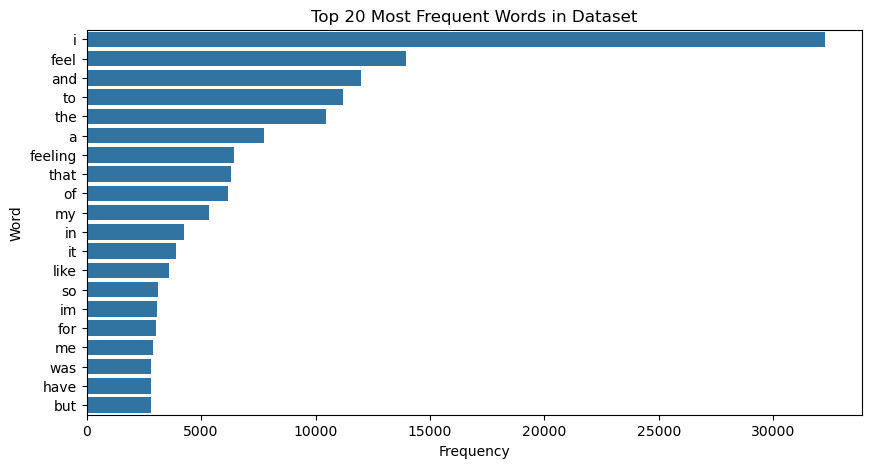

In [9]:
from collections import Counter
import re

# Collect all words from the dataset
words = []
for text in df["text"]:
    # Convert text to lowercase and extract words
    tokens = re.findall(r"\b\w+\b", text.lower())
    words.extend(tokens)

# Get the 20 most common words
common_words = Counter(words).most_common(20)

# Convert to DataFrame for visualization
word_df = pd.DataFrame(common_words, columns=["Word", "Frequency"])

# Plot frequent words
plt.figure(figsize=(10,5))
sns.barplot(x="Frequency", y="Word", data=word_df)
plt.title("Top 20 Most Frequent Words in Dataset")
plt.show()


# Train Test Split

In [10]:
from sklearn.model_selection import train_test_split
# Separate features (text) and target (label)
X = df["text"]
y = df["label"]

# Split dataset into training and testing sets
# stratify=y ensures class balance in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# TF-IDF Vectorizor

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    max_features=10000
)

# Fit TF-IDF on training data and transform both sets
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# 1) Naive Bayes Algorithm

## Initial Classification Report from MUltinomial Naive Bayes

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize Naive Bayes classifier
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train_tfidf, y_train)

# Predict on test data
nb_preds = nb_model.predict(X_test_tfidf)

# Display performance metrics
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds))


Naive Bayes Accuracy: 0.77475
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1159
           1       0.72      0.98      0.83      1352
           2       0.97      0.24      0.38       328
           3       0.95      0.58      0.72       542
           4       0.92      0.58      0.71       475
           5       1.00      0.09      0.17       144

    accuracy                           0.77      4000
   macro avg       0.89      0.57      0.61      4000
weighted avg       0.82      0.77      0.74      4000



## Initial Predicted Result

In [39]:
# Initial Prediction
pred = nb_model.predict(vectorizer.transform(["i was feeling pretty anxious all day but my first day at work was a very good day and that helped a lot"]))[0]


print("Predicted emotion:", emotion_map[pred])

Predicted emotion: Joy


### Hyperparameter Tuning - Multinomial Naive Bayes

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define hyperparameter grid for Naive Bayes
nb_param_grid = {
    "alpha": [0.1, 0.5, 1.0, 1.5, 2.0]  # Smoothing parameter
}

# Initialize GridSearchCV
nb_grid = GridSearchCV(
    MultinomialNB(),
    nb_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Fit grid search on training data
nb_grid.fit(X_train_tfidf, y_train)

# Get best model
nb_best_model = nb_grid.best_estimator_

print("Best Naive Bayes alpha:", nb_grid.best_params_)


Best Naive Bayes alpha: {'alpha': 0.1}


## Classification report after hyperparameter tuning

In [14]:
from sklearn.metrics import accuracy_score, classification_report

# Predict using tuned model
nb_tuned_preds = nb_best_model.predict(X_test_tfidf)

# Accuracy and report
nb_tuned_accuracy = accuracy_score(y_test, nb_tuned_preds)

print("Tuned Naive Bayes Accuracy:", nb_tuned_accuracy)
print(classification_report(y_test, nb_tuned_preds))


Tuned Naive Bayes Accuracy: 0.84575
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1159
           1       0.82      0.94      0.88      1352
           2       0.88      0.55      0.68       328
           3       0.91      0.79      0.84       542
           4       0.88      0.77      0.82       475
           5       0.89      0.43      0.58       144

    accuracy                           0.85      4000
   macro avg       0.87      0.74      0.78      4000
weighted avg       0.85      0.85      0.84      4000



## Predicted result after hyperparameter tuning

In [31]:
# Predict a new sentence using the tuned Naive Bayes model
pred_after = nb_best_model.predict(vectorizer.transform(["i was feeling pretty anxious all day but my first day at work was a very good day and that helped a lot"]))[0]

# Map numeric prediction to emotion
print("Predicted emotion after tuning:", emotion_map[pred_after])


Predicted emotion after tuning: Fear


# Logistic Regression

## Initial Classification Report from Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression classifier
lr_model = LogisticRegression(
    max_iter=2000,
    C=2.0
)

# Train the model
lr_model.fit(X_train_tfidf, y_train)

# Predict on test data
lr_preds = lr_model.predict(X_test_tfidf)

# Display performance metrics
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))


Logistic Regression Accuracy: 0.89775
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1159
           1       0.89      0.95      0.92      1352
           2       0.84      0.77      0.80       328
           3       0.92      0.87      0.90       542
           4       0.89      0.85      0.87       475
           5       0.86      0.64      0.73       144

    accuracy                           0.90      4000
   macro avg       0.89      0.84      0.86      4000
weighted avg       0.90      0.90      0.90      4000



## Initial Predicted Result


In [32]:
pred_lr_before = lr_model.predict(vectorizer.transform(["i was feeling pretty anxious all day but my first day at work was a very good day and that helped a lot"]))[0]
print("Logistic Regression Prediction before tuning:", emotion_map[pred_lr_before])

Logistic Regression Prediction before tuning: Joy


## Hyperparameter Tuning - Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_param_grid = {
    "C": [0.1, 0.5, 1, 2, 5],
    "solver": ["lbfgs"],
    "max_iter": [1000, 2000]
}

# Initialize GridSearchCV without multi_class
lr_grid = GridSearchCV(
    LogisticRegression(),
    lr_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

lr_grid.fit(X_train_tfidf, y_train)

lr_best_model = lr_grid.best_estimator_

print("Best Logistic Regression parameters:", lr_grid.best_params_)



Best Logistic Regression parameters: {'C': 5, 'max_iter': 1000, 'solver': 'lbfgs'}


## Classification Report After Hyperparameter Tuning

In [20]:
# Predict using tuned model
lr_tuned_preds = lr_best_model.predict(X_test_tfidf)

# Accuracy and report
lr_tuned_accuracy = accuracy_score(y_test, lr_tuned_preds)

print("Tuned Logistic Regression Accuracy:", lr_tuned_accuracy)
print(classification_report(y_test, lr_tuned_preds))


Tuned Logistic Regression Accuracy: 0.90075
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1159
           1       0.90      0.94      0.92      1352
           2       0.83      0.79      0.81       328
           3       0.91      0.88      0.90       542
           4       0.89      0.86      0.87       475
           5       0.83      0.68      0.75       144

    accuracy                           0.90      4000
   macro avg       0.88      0.85      0.86      4000
weighted avg       0.90      0.90      0.90      4000



## Predicted Result After Tuning

In [36]:
# After tuning
pred_lr_after = lr_best_model.predict(vectorizer.transform(["i was feeling pretty anxious all day but my first day at work was a very good day and that helped a lot"]))[0]
print("Logistic Regression Prediction after tuning:", emotion_map[pred_lr_after])

Logistic Regression Prediction after tuning: Fear


# Before vs After Hyperparameter Tuning Accuracy

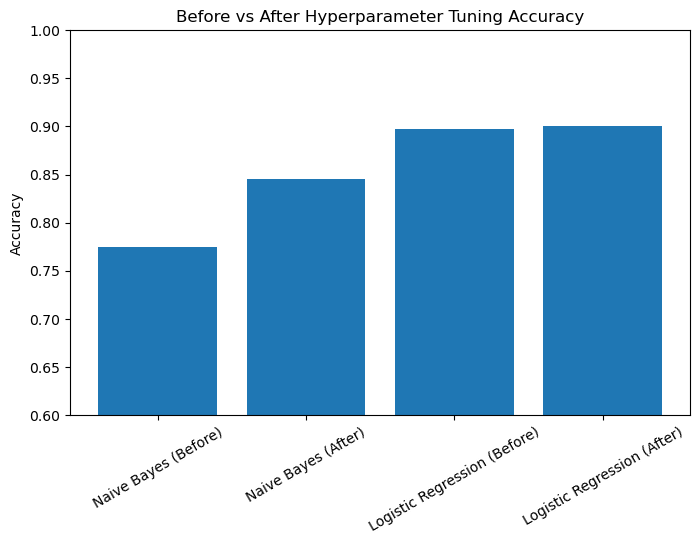

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Create accuracy comparison table
accuracy_df = pd.DataFrame({
    "Model": [
        "Naive Bayes (Before)",
        "Naive Bayes (After)",
        "Logistic Regression (Before)",
        "Logistic Regression (After)"
    ],
    "Accuracy": [
        accuracy_score(y_test, nb_preds),
        nb_tuned_accuracy,
        accuracy_score(y_test, lr_preds),
        lr_tuned_accuracy
    ]
})

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(accuracy_df["Model"], accuracy_df["Accuracy"])
plt.title("Before vs After Hyperparameter Tuning Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.ylim(0.6, 1.0)
plt.show()


# Save .pkl files for Streamlit

In [24]:
import joblib

# ---------------------------
# Save Naive Bayes models
# ---------------------------
joblib.dump(nb_model, "nb_model_before.pkl")       # original Naive Bayes
joblib.dump(nb_best_model, "nb_model_after.pkl")   # tuned Naive Bayes

# ---------------------------
# Save Logistic Regression models
# ---------------------------
joblib.dump(lr_model, "lr_model_before.pkl")       # original Logistic Regression
joblib.dump(lr_best_model, "lr_model_after.pkl")   # tuned Logistic Regression

# ---------------------------
# Save TF-IDF vectorizer
# ---------------------------
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# ---------------------------
# Save test set for accuracy comparison
# ---------------------------
joblib.dump(X_test_tfidf, "X_test_tfidf.pkl")
joblib.dump(y_test, "y_test.pkl")


['y_test.pkl']

# Naive Bayes Prediction Comparison (Before vs After Tuning)

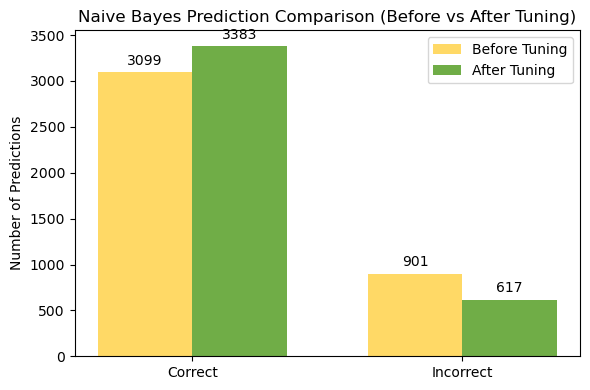

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred_before_nb = nb_model_before.predict(X_test_tfidf)
y_pred_after_nb = nb_model_after.predict(X_test_tfidf)

# Count correct and incorrect
before_correct_nb = (y_pred_before_nb == y_test).sum()
before_incorrect_nb = (y_pred_before_nb != y_test).sum()
after_correct_nb = (y_pred_after_nb == y_test).sum()
after_incorrect_nb = (y_pred_after_nb != y_test).sum()

# Data for plotting
labels = ["Correct", "Incorrect"]
before = [before_correct_nb, before_incorrect_nb]
after = [after_correct_nb, after_incorrect_nb]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(6,4))
rects1 = ax.bar(x - width/2, before, width, label='Before Tuning', color="#FFD966")
rects2 = ax.bar(x + width/2, after, width, label='After Tuning', color="#70AD47")

# Labels and title
ax.set_ylabel("Number of Predictions")
ax.set_title("Naive Bayes Prediction Comparison (Before vs After Tuning)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()



# Naive Bayes Prediction Confidence (Before vs After Tuning)

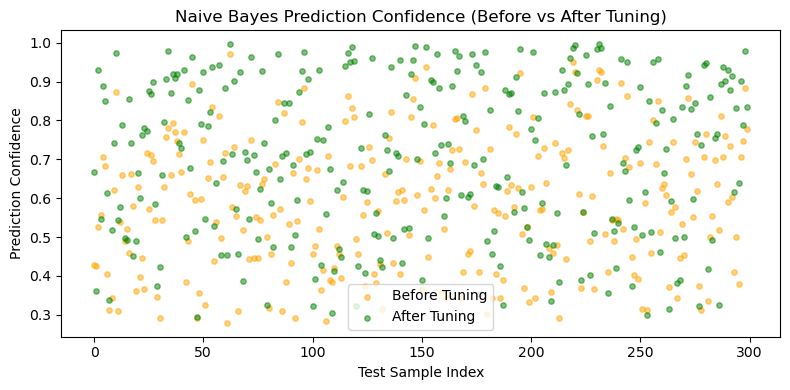

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Limit samples for clarity
N = 300  

# Prediction confidence
nb_before_conf = nb_model_before.predict_proba(X_test_tfidf)[:N].max(axis=1)
nb_after_conf = nb_model_after.predict_proba(X_test_tfidf)[:N].max(axis=1)

x = np.arange(N)

plt.figure(figsize=(8,4))

plt.scatter(x, nb_before_conf,
            s=15, alpha=0.5, label="Before Tuning", color="orange")

plt.scatter(x, nb_after_conf,
            s=15, alpha=0.5, label="After Tuning", color="green")

plt.title("Naive Bayes Prediction Confidence (Before vs After Tuning)")
plt.xlabel("Test Sample Index")
plt.ylabel("Prediction Confidence")
plt.legend()
plt.tight_layout()
plt.show()


# Logistic Regression Prediction Comparison (Before vs After Tuning)

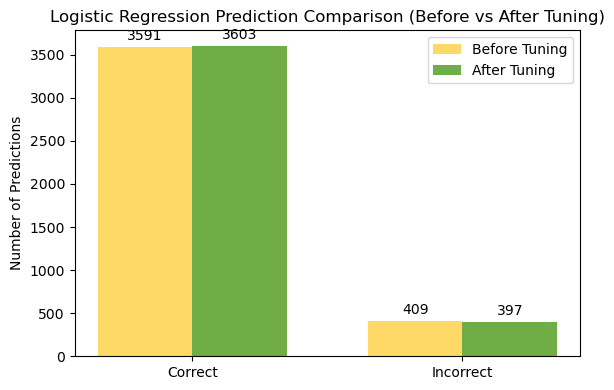

In [50]:
# Predictions
y_pred_before_lr = lr_model_before.predict(X_test_tfidf)
y_pred_after_lr = lr_model_after.predict(X_test_tfidf)

# Count correct and incorrect
before_correct_lr = (y_pred_before_lr == y_test).sum()
before_incorrect_lr = (y_pred_before_lr != y_test).sum()
after_correct_lr = (y_pred_after_lr == y_test).sum()
after_incorrect_lr = (y_pred_after_lr != y_test).sum()

# Data for plotting
labels = ["Correct", "Incorrect"]
before = [before_correct_lr, before_incorrect_lr]
after = [after_correct_lr, after_incorrect_lr]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
rects1 = ax.bar(x - width/2, before, width, label='Before Tuning', color="#FFD966")
rects2 = ax.bar(x + width/2, after, width, label='After Tuning', color="#70AD47")

ax.set_ylabel("Number of Predictions")
ax.set_title("Logistic Regression Prediction Comparison (Before vs After Tuning)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()



# Logistic Regression Prediction Confidence (Before vs After Tuning)

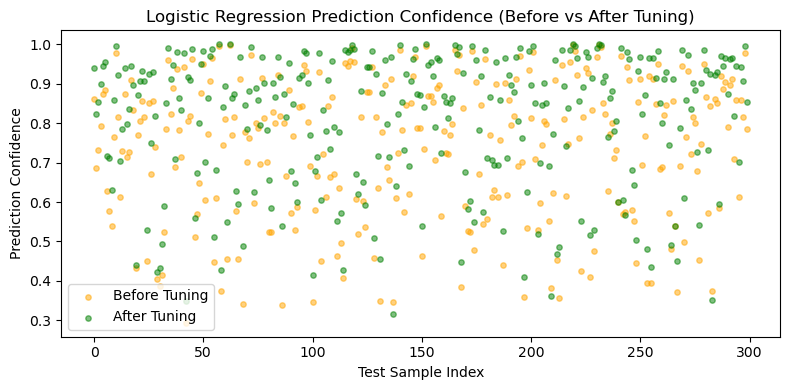

In [51]:
# Limit samples
N = 300  

# Prediction confidence
lr_before_conf = lr_model_before.predict_proba(X_test_tfidf)[:N].max(axis=1)
lr_after_conf = lr_model_after.predict_proba(X_test_tfidf)[:N].max(axis=1)

x = np.arange(N)

plt.figure(figsize=(8,4))

plt.scatter(x, lr_before_conf,
            s=15, alpha=0.5, label="Before Tuning", color="orange")

plt.scatter(x, lr_after_conf,
            s=15, alpha=0.5, label="After Tuning", color="green")

plt.title("Logistic Regression Prediction Confidence (Before vs After Tuning)")
plt.xlabel("Test Sample Index")
plt.ylabel("Prediction Confidence")
plt.legend()
plt.tight_layout()
plt.show()


# Classification Reports of both models before and after tuning

In [54]:
from sklearn.metrics import accuracy_score, classification_report

print("=" * 70)
print("NAIVE BAYES PERFORMANCE METRICS (BEFORE TUNING)".center(70))
print("=" * 70)

print(f"Accuracy : {accuracy_score(y_test, nb_preds):.4f}\n")

print("Classification Report")
print("-" * 70)
print(classification_report(y_test, nb_preds))

print("=" * 70)


           NAIVE BAYES PERFORMANCE METRICS (BEFORE TUNING)            
Accuracy : 0.7748

Classification Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1159
           1       0.72      0.98      0.83      1352
           2       0.97      0.24      0.38       328
           3       0.95      0.58      0.72       542
           4       0.92      0.58      0.71       475
           5       1.00      0.09      0.17       144

    accuracy                           0.77      4000
   macro avg       0.89      0.57      0.61      4000
weighted avg       0.82      0.77      0.74      4000



In [55]:
print("=" * 70)
print("NAIVE BAYES PERFORMANCE METRICS (AFTER TUNING)".center(70))
print("=" * 70)

print(f"Accuracy : {accuracy_score(y_test, nb_tuned_preds):.4f}\n")

print("Classification Report")
print("-" * 70)
print(classification_report(y_test, nb_tuned_preds))

print("=" * 70)


            NAIVE BAYES PERFORMANCE METRICS (AFTER TUNING)            
Accuracy : 0.8458

Classification Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1159
           1       0.82      0.94      0.88      1352
           2       0.88      0.55      0.68       328
           3       0.91      0.79      0.84       542
           4       0.88      0.77      0.82       475
           5       0.89      0.43      0.58       144

    accuracy                           0.85      4000
   macro avg       0.87      0.74      0.78      4000
weighted avg       0.85      0.85      0.84      4000



In [58]:
print("=" * 70)
print("LOGISTIC REGRESSION PERFORMANCE METRICS (BEFORE TUNING)".center(70))
print("=" * 70)

print(f"Accuracy : {accuracy_score(y_test, lr_preds):.4f}\n")

print("Classification Report")
print("-" * 70)
print(classification_report(y_test, lr_preds))

print("=" * 70)



       LOGISTIC REGRESSION PERFORMANCE METRICS (BEFORE TUNING)        
Accuracy : 0.8978

Classification Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1159
           1       0.89      0.95      0.92      1352
           2       0.84      0.77      0.80       328
           3       0.92      0.87      0.90       542
           4       0.89      0.85      0.87       475
           5       0.86      0.64      0.73       144

    accuracy                           0.90      4000
   macro avg       0.89      0.84      0.86      4000
weighted avg       0.90      0.90      0.90      4000



In [57]:
print("=" * 70)
print("LOGISTIC REGRESSION PERFORMANCE METRICS (AFTER TUNING)".center(70))
print("=" * 70)

print(f"Accuracy : {accuracy_score(y_test, lr_tuned_preds):.4f}\n")

print("Classification Report")
print("-" * 70)
print(classification_report(y_test, lr_tuned_preds))

print("=" * 70)


        LOGISTIC REGRESSION PERFORMANCE METRICS (AFTER TUNING)        
Accuracy : 0.9008

Classification Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1159
           1       0.90      0.94      0.92      1352
           2       0.83      0.79      0.81       328
           3       0.91      0.88      0.90       542
           4       0.89      0.86      0.87       475
           5       0.83      0.68      0.75       144

    accuracy                           0.90      4000
   macro avg       0.88      0.85      0.86      4000
weighted avg       0.90      0.90      0.90      4000

